# Lecture 1 - Introduction

Julia Yan

*Acknowledgment:* Lazy DFJ implementation adapted from the [JuMP documentation](https://jump.dev/JuMP.jl/stable/tutorials/algorithms/tsp_lazy_constraints/).

##  Header

In [1]:
# # Dependencies: Uncomment and run this cell if you don't have these packages 
# Pkg.add("JuMP")
# Pkg.add("Gurobi")
# Pkg.add("Combinatorics")
# Pkg.add("Plots")

In [2]:
include("src/data.jl");
include("src/opt.jl");
include("src/out.jl");

## Data Input

Optimizer

In [3]:
env = Gurobi.Env()
optimizer = JuMP.optimizer_with_attributes(() -> Gurobi.Optimizer(env), "TimeLimit" => 30);

Set parameter Username
Academic license - for non-commercial use only - expires 2024-12-05


Generate instance data

In [4]:
# One instance to deep-dive into each model
dat = TSPInstance(20, random_seed = 1)

# Instances of varying sizes to compare the scalability of each model
all_n = [2^k for k in 3:7]
dat_dict = Dict()
for n in all_n
    dat_dict[n] = TSPInstance(n, random_seed = 1)
end

## MTZ Formulation

### How does MTZ work?

Generate instance data and build MTZ model

In [5]:
mdl_mtz = TSPModel(dat, optimizer = optimizer)
@time add_mtz_constraints!(mdl_mtz)

Set parameter TimeLimit to value 30
  0.395117 seconds (1.22 M allocations: 64.847 MiB, 99.52% compilation time)


Solve problem. On my laptop, we find the optimal solution in 1.5 seconds.

In [6]:
solution_mtz = solve!(mdl_mtz)

Set parameter TimeLimit to value 30
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (mac64[arm])

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 841 rows, 420 columns and 2665 nonzeros
Model fingerprint: 0x80dc5678
Variable types: 20 continuous, 400 integer (400 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [2e-02, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Presolve removed 269 rows and 21 columns
Presolve time: 0.00s
Presolved: 572 rows, 399 columns, 2166 nonzeros
Variable types: 19 continuous, 380 integer (380 binary)
Found heuristic solution: objective 11.8815569

Root relaxation: objective 3.139606e+00, 63 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    3.13961    0   26   

TSP Solution with 20 cities

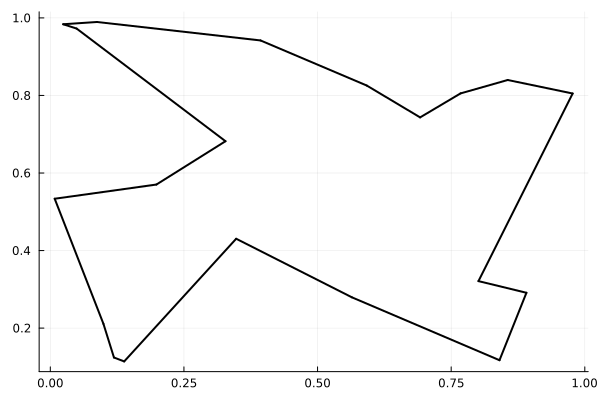

In [7]:
plot_tour(solution_mtz)

Inspect values of labeling variables

In [8]:
u_value = round.(Int, JuMP.value.(mdl_mtz.model[:u]))
@assert all(isapprox.(u_value, JuMP.value.(mdl_mtz.model[:u]))) # Check that u value is indeed integral
println(u_value)

[1, 16, 4, 2, 6, 7, 3, 8, 12, 11, 15, 14, 19, 18, 5, 10, 13, 20, 9, 17]


In [9]:
for i=sortperm(u_value)
    println(
        lpad(string(u_value[i]), 2, ' '), ": ",    # Ordering
        "Node ", lpad(string(i), 2, ' '), " at ",  # Node index
        round.(dat.coords[i,:], digits=3)          # Coordinates
    )
end

 1: Node  1 at [0.049, 0.973]
 2: Node  4 at [0.024, 0.984]
 3: Node  7 at [0.087, 0.989]
 4: Node  3 at [0.393, 0.942]
 5: Node 15 at [0.592, 0.826]
 6: Node  5 at [0.692, 0.743]
 7: Node  6 at [0.768, 0.805]
 8: Node  8 at [0.856, 0.84]
 9: Node 19 at [0.977, 0.805]
10: Node 16 at [0.801, 0.321]
11: Node 10 at [0.891, 0.291]
12: Node  9 at [0.84, 0.117]
13: Node 17 at [0.564, 0.279]
14: Node 12 at [0.348, 0.43]
15: Node 11 at [0.138, 0.114]
16: Node  2 at [0.119, 0.124]
17: Node 20 at [0.099, 0.211]
18: Node 14 at [0.008, 0.534]
19: Node 13 at [0.199, 0.57]
20: Node 18 at [0.328, 0.682]


## DFJ Formulation

### Issue: Exponential number of constraints

Build full DFJ model with all subtour elimination constraints

In [10]:
mdl_dfj_full = TSPModel(dat, optimizer = optimizer)
@time add_dfj_constraints!(mdl_dfj_full)

Set parameter TimeLimit to value 30
  9.918102 seconds (24.75 M allocations: 12.355 GiB, 17.75% gc time, 1.47% compilation time: 45% of which was recompilation)

┌ Warning: Full DFJ model not recommended for large n
└ @ Main ~/Documents/GitHub/OptTeaching/01-tsp/src/opt.jl:63


Solve problem. On my laptop, we cannot find an optimal solution in the 30s time limit. Gurobi finds a heuristic solution and then gets stuck in presolve because of the large number of constraints. 

In [11]:
solution_dfj_full = solve!(mdl_dfj_full)

Set parameter TimeLimit to value 30
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (mac64[arm])

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 1049014 rows, 400 columns and 110101660 nonzeros
Model fingerprint: 0x72c35d7c
Variable types: 0 continuous, 400 integer (400 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [2e-02, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+01]
Found heuristic solution: objective 12.1674561
Presolve removed 20 rows and 20 columns (presolve time = 7s) ...
Presolve removed 40 rows and 20 columns (presolve time = 19s) ...
Presolve removed 40 rows and 20 columns (presolve time = 30s) ...
Presolve removed 40 rows and 20 columns
Presolve time: 30.35s

Explored 0 nodes (0 simplex iterations) in 33.30 seconds (17.89 work units)
Thread count was 1 (of 10 available processors)

Solution count 1: 12.1675 

Time limit reached
Be

TSP Solution with 20 cities

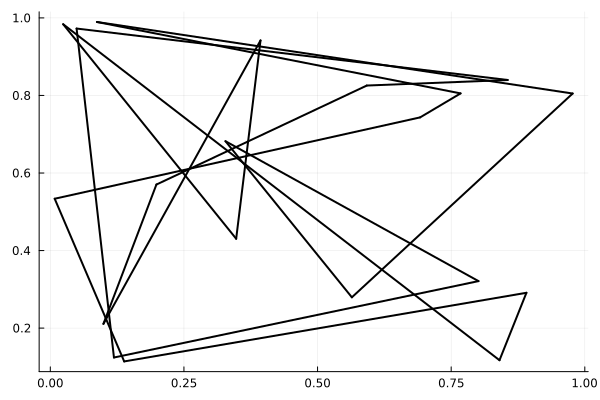

In [12]:
plot_tour(solution_dfj_full)

### Solution: Add constraints lazily

Now, we illustrate the DFJ formulation with a callback to implement subtour elimination constraints that are lazily added in the branch-and-bound tree. This code also illustrates examples of subtours.

Build DFJ model 

In [13]:
mdl_dfj = TSPModel(dat, optimizer = optimizer)
add_dfj_callback!(mdl_dfj)

Set parameter TimeLimit to value 30


Solve problem

In [14]:
solution_dfj = solve!(mdl_dfj)

Set parameter TimeLimit to value 30
Set parameter LazyConstraints to value 1
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (mac64[arm])

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 460 rows, 400 columns and 1600 nonzeros
Model fingerprint: 0xc8eea1c1
Variable types: 0 continuous, 400 integer (400 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [2e-02, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 230 rows and 20 columns
Presolve time: 0.00s
Presolved: 230 rows, 380 columns, 1140 nonzeros
Variable types: 0 continuous, 380 integer (380 binary)

Root relaxation: objective 3.139606e+00, 47 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    3.13961    0   20          -

TSP Solution with 20 cities

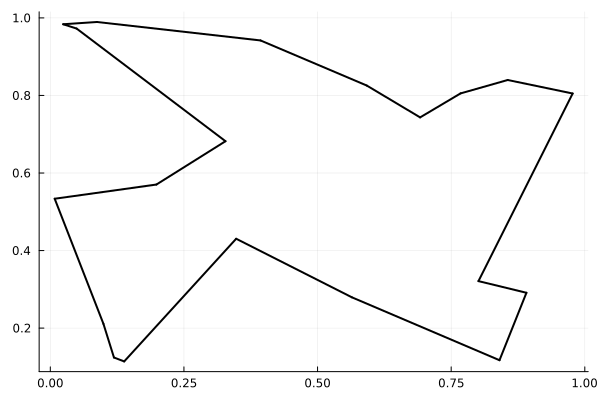

In [15]:
plot_tour(solution_dfj)

When an integer solution is found, this model looks for subtours, adds the corresponding subtour elimination constraint (for the shortest subtour), then resolves. These plots show the subtours at each iteration, highlighting the shortest subtour in red.

11 lazy constraints


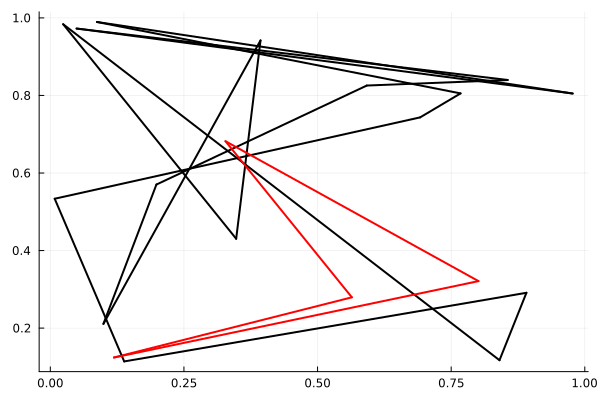

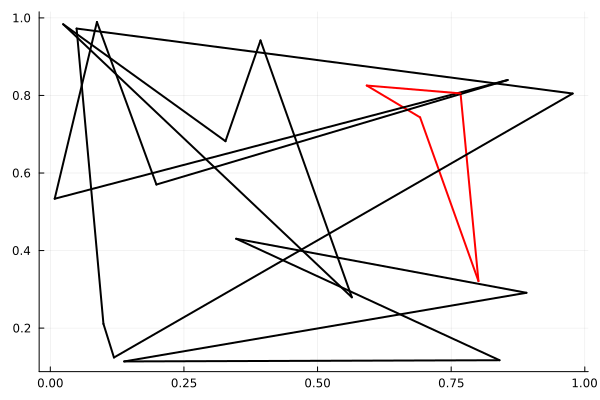

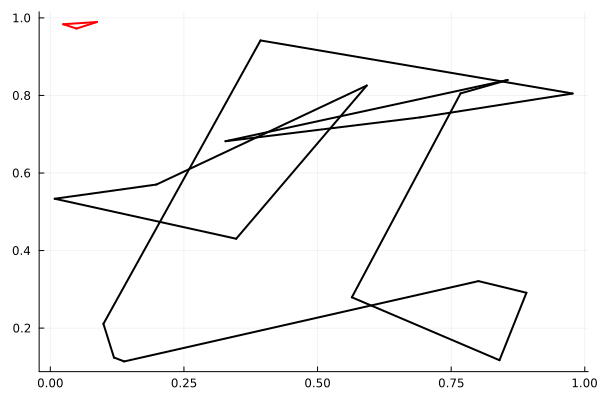

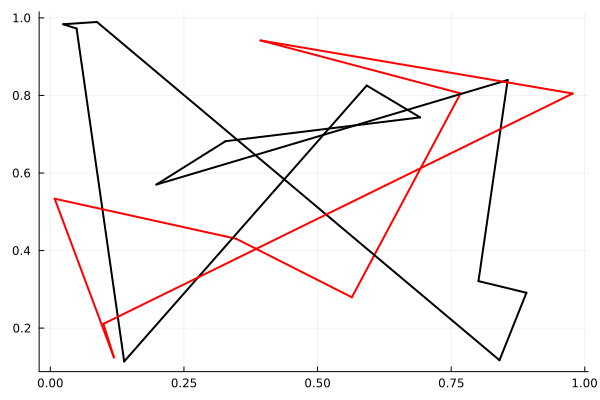

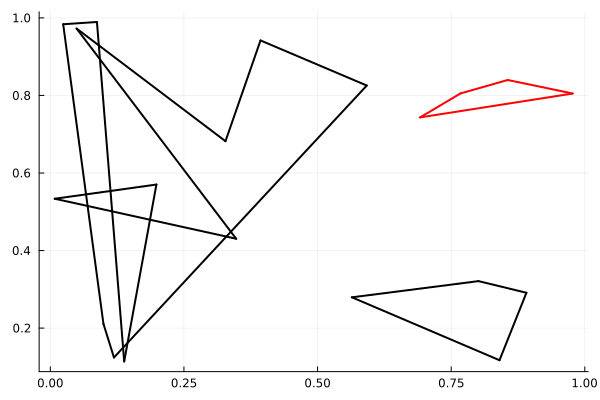

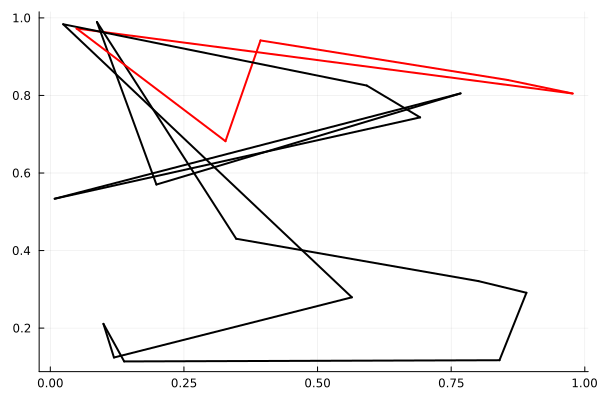

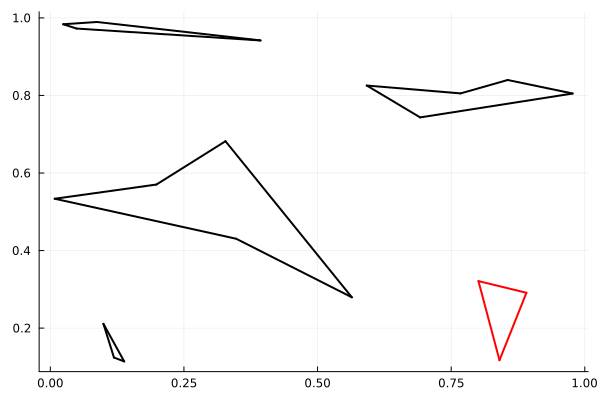

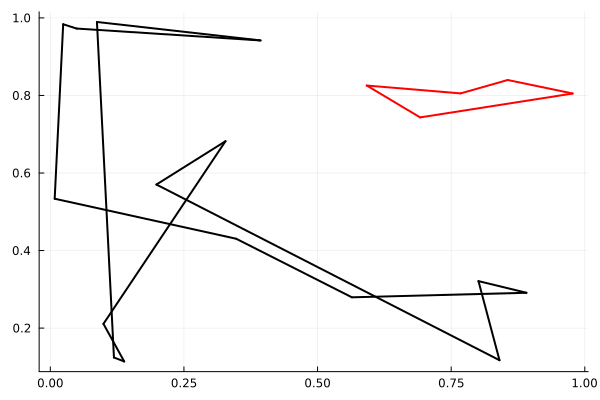

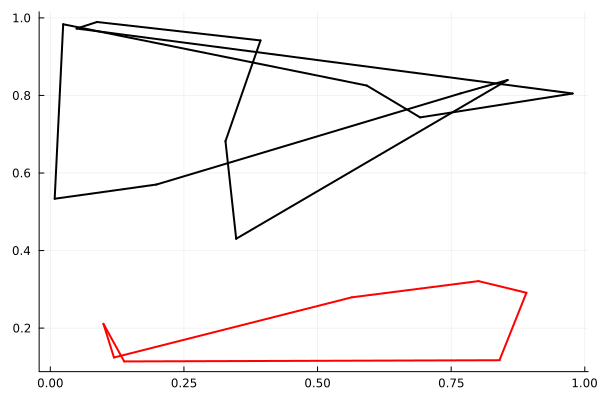

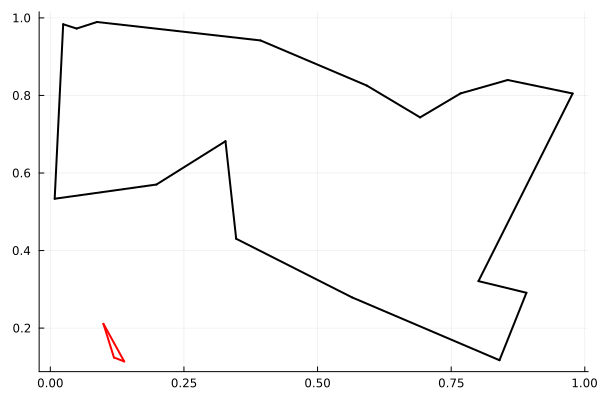

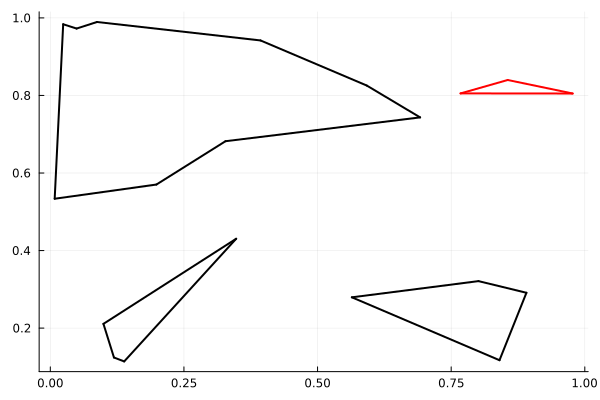

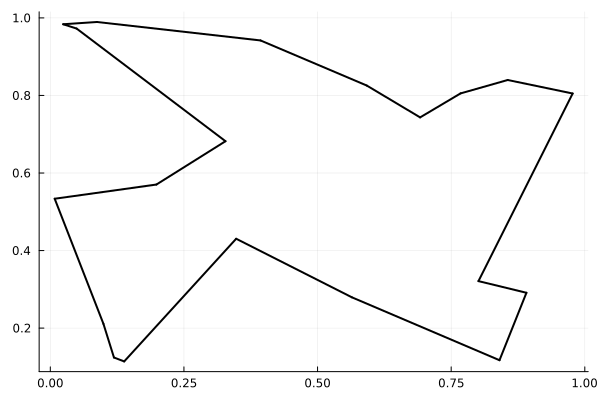

In [16]:
# Print subtours
println(length(mdl_dfj.aux["solution"]), " lazy constraints")
for k=1:length(mdl_dfj.aux["solution"])
    plt = plot_tour(dat, mdl_dfj.aux["solution"][k], highlight = mdl_dfj.aux["subtour"][k])
    display(plt)
end

# Print optimal solution
plot_tour(solution_dfj)

## Comparison of MTZ and DFJ

### One instance

Show solve times for each IP on the 20-city instance that we saw before. Note that both run quickly on this instance (the difference will become more apparent when we look at larger numbers of cities).

In [17]:
println("MTZ Model: ", solution_mtz.solve_time, " seconds")
println("DFJ Model: ", solution_dfj.solve_time, " seconds")

MTZ Model: 1.4858970642089844 seconds
DFJ Model: 0.2607991695404053 seconds


### Varying problem size

Solve models for varying problem sizes

In [18]:
all_solve_times = Dict()
all_objective_values = Dict()
@time for n in all_n
    
    for (key, fn) in [("DFJ", add_dfj_callback!), ("MTZ", add_mtz_constraints!)]
        
        mdl_key = TSPModel(dat_dict[n], optimizer = optimizer, silent = true)
        fn(mdl_key)
        solution_key = solve!(mdl_key)

        if haskey(all_solve_times, key)
            push!(all_solve_times[key], solution_key.solve_time)
            push!(all_objective_values[key], solution_key.objective_value)
        else
            all_solve_times[key] = [solution_key.solve_time]
            all_objective_values[key] = [solution_key.objective_value]
        end
        
    end

end

Set parameter TimeLimit to value 30
Set parameter TimeLimit to value 30
Set parameter TimeLimit to value 30
Set parameter TimeLimit to value 30
Set parameter TimeLimit to value 30
Set parameter TimeLimit to value 30
Set parameter TimeLimit to value 30
Set parameter TimeLimit to value 30
Set parameter TimeLimit to value 30
Set parameter TimeLimit to value 30
 36.008879 seconds (10.28 M allocations: 382.022 MiB, 0.16% compilation time)


Plot results

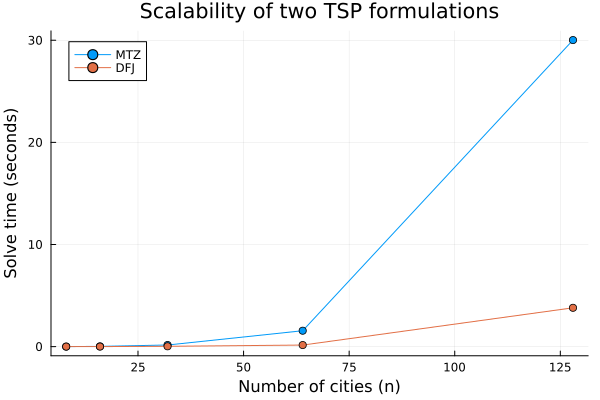

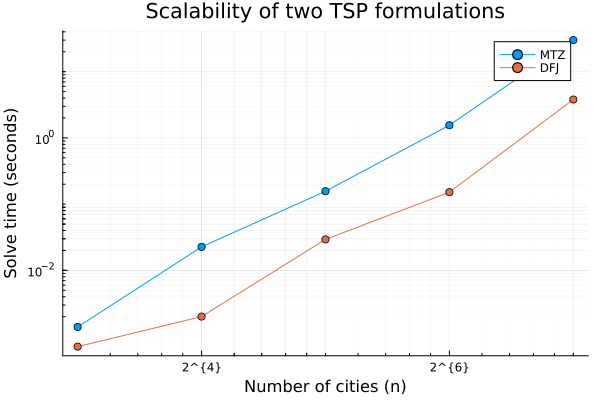

In [19]:
for log_scale in [false, true]
    plt = Plots.plot()
    for key in keys(all_solve_times)
        Plots.plot!(all_n, all_solve_times[key], label = key, marker = :circle)    
    end
    if log_scale
        Plots.plot!(xscale = :log2, yscale = :log10, minorgrid = true)
    end
    title!("Scalability of two TSP formulations")
    xlabel!("Number of cities (n)")
    ylabel!("Solve time (seconds)")
    display(plt)
end

### LP Relaxations

Solve the LP relaxations on the 16-city instance, for which we can solve the (relaxed) DFJ model with all constraints. The MTZ formulation is weaker.

In [20]:
this_n = 16

# MTZ
mdl_mtz_lp = TSPModel(dat_dict[this_n], optimizer = optimizer)
@time add_mtz_constraints!(mdl_mtz_lp)
JuMP.relax_integrality(mdl_mtz_lp.model)
optimize!(mdl_mtz_lp.model)

# DFJ
mdl_dfj_lp = TSPModel(dat_dict[this_n], optimizer = optimizer)
@time add_dfj_constraints!(mdl_dfj_lp)
JuMP.relax_integrality(mdl_dfj_lp.model)
optimize!(mdl_dfj_lp.model)

Set parameter TimeLimit to value 30
  0.000453 seconds (8.71 k allocations: 673.000 KiB)
Set parameter TimeLimit to value 30
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (mac64[arm])

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 545 rows, 272 columns and 1685 nonzeros
Model fingerprint: 0x4f6451d4
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [7e-02, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Presolve removed 184 rows and 17 columns
Presolve time: 0.00s
Presolved: 361 rows, 255 columns, 1335 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.4073826e+00   3.575000e+01   0.000000e+00      0s
      42    3.4269040e+00   0.000000e+00   0.000000e+00      0s

Solved in 42 iterations and 0.00 seconds (0.00 work units)
Optimal objective  3.426904042e+00

User-callback calls 102, time in user-callback 0.00 sec
S

Compare the objective values. The MTZ formulation is weaker (it has the lower objective value). In this case, the DFJ LP objective value matches the IP objective value, although this is not always the case.

In [21]:
println("MTZ LP Objective Value:\t", objective_value(mdl_mtz_lp.model))
println("DFJ LP Objective Value:\t", objective_value(mdl_dfj_lp.model))
println("IP Objective Value:\t", all_objective_values["DFJ"][findfirst(all_n .== this_n)])

MTZ LP Objective Value:	3.426904042406376
DFJ LP Objective Value:	3.499813101274573
IP Objective Value:	3.499813101274573
